In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as td
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class prior(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
        
    def forward(self):
    #returns the prior distribution - this class is probably unnecessary since we're not going to mess with the prior.
    
        return td.Normal(torch.zeros(self.dim), torch.eye(self.dim))

    

<h1><center> The Diffusion/Forward Process </center> </h1>

In [92]:
class diffusion_process(nn.Module):
    
    def __init__(self, time_steps, beta_1, beta_T):
        super().__init__()
        """
        beta_1 and beta_T are the variances for q(x_1|x_0) and q(x_T|x_{T-1}) respectively
        beta_T should be larger, and we'll linearly interpolate between these to set the variances of the diffusion process.
        """
        
        self.variance_schedule = torch.linspace(beta_1, beta_T, time_steps)   #could be learned (Kingma et al), but we'll start with fixed.
        self.T = time_steps
        
        
    def forward_var(self, t):
        """
        The variance schedule records the variances of q(x_{t}| x_{t-1}) - this returns the variance of q(x_t| x_0)
        """
        alpha = 1 
        if t > 0:
            for s in range(t):
                alpha = alpha*(1-self.variance_schedule[s])
            var = 1-alpha
        else:
            var = self.variance_schedule[0]
        
        return var
        
        
        
    def forward(self, x, t, inc_dist = False):
        """
        starting with an input image x and a timestep t between 0 and 1, we return a sample z_{t} from q(z_t | x) and the corresponding log probability.
        We'll always work in closed form rather than performing a sequence of samples.
        """

        var = self.forward_var(t)
        mu = (1-var)**.5
        
        cond_t = td.Normal(mu*x, var) #equation 4 in Ho et al - cond_t = q(x_t | x_0)
        
        z_t = cond_t.rsample()
        log_prob = cond_t.log_prob(z_t)
        
        if inc_dist:
            return z_t, log_prob
        else:
            return z_t
    
    
        
        
        

**An Example:**

In [93]:
                 
toy_diffusion = diffusion_process(500, .0001, .004)


In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

cifar_train = datasets.CIFAR10(root = './data', train = True, download = True, transform = ToTensor())
cifar_test = datasets.CIFAR10(root = './data', train = False, download = True, transform = ToTensor())

mnist_train = datasets.MNIST(root = './data', train = True, download = True, transform = ToTensor())
mnist_test = datasets.MNIST(root = './data', train = True, download = True, transform = ToTensor())

Files already downloaded and verified
Files already downloaded and verified


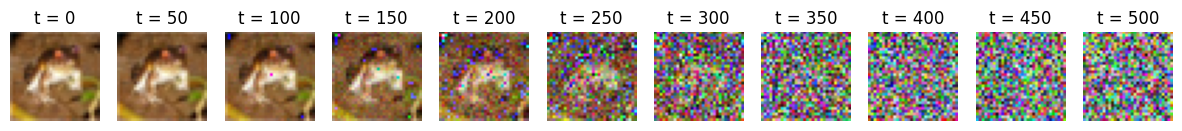

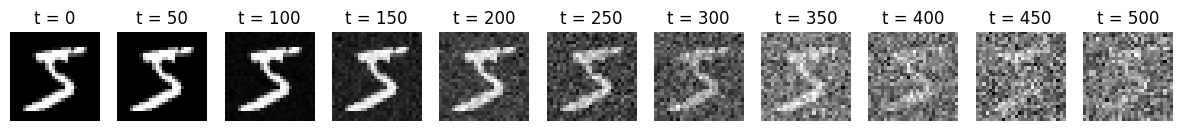

In [94]:
im, label = cifar_train[0]

images = [im]


for t in range(10):
    images.append(toy_diffusion(im, 50*t))


figure = plt.figure(figsize=(15,15))


for i in range(11):
    figure.add_subplot(1,11,i+1)
    plt.axis("off")
    plt.title("t = {}".format(50*i))
    im = images[i].numpy().transpose(1,2,0)
    plt.imshow((im*255).astype(np.uint8), cmap = "gray")
    

    
im, label = mnist_train[0]

images = [im]


for t in range(10):
    images.append(toy_diffusion(im, 50*t))


new_figure = plt.figure(figsize=(15,15))


for i in range(11):
    new_figure.add_subplot(1,11,i+1)
    plt.axis("off")
    plt.title("t = {}".format(50*i))
    plt.imshow(images[i].numpy().transpose(1,2,0), cmap = "gray")

    
    


Looks pretty good!

<h1> <center> Denoising Neural Network/Backward Process </center> </h1>
I think in general, the neural networks used in diffusion models are pretty sophisticated - however, we could likely start with something pretty simple and try to get a model that can at least learn something. Once we get something off the ground and running, we could try to introduce more sophisticated denoising networks.

In [95]:
class denoise_net(nn.Module):
    def __init__(self, dif_proc, net):
        super().__init__()
        self.dif_proc = dif_proc
        self.net = net
        
    def forward(self, z_t, t):
        #should take in a pair (z_t, t) and spit out epsilon(z_t, t)
        #epsilon should be a U-net neural network, as in Ho et al.
        return self.net(z_t, t)
        
    def denoise(self, z_t, t):
        #should take in a pair (z_t, t) and spit out the neural networks reconstruction of x from z_t
        var_t = self.dif_proc.forward_var(t) #Equation 3
        alpha_t = (1-var_t)**.5
                
        return (z_t - var_t*self.net(z_t,t))/alpha_t #Equation 10
        
    

**Silly Example to Check Code Compiles:**

In [96]:
class toy_denoising_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(3073, 3072)
        torch.nn.init.xavier_uniform_(self.layer_1.weight)
        
    def forward(self, z_t, t):
        #z_t is a tensor of size [batch_size, 3, 32, 32] and t is a scalar. 
        z_t = z_t.view(-1, 3072) 
        batch_size = z_t.size()[0]       
        t_tens = t*torch.ones((batch_size, 1))  
        
        z_t = torch.cat((z_t, t_tens), dim=1) #incorporate time step in to each sample
        
        x_rec = self.layer_1(z_t)
        activation = torch.nn.ReLU()
        x_rec = activation(x_rec)
        
        x_rec = x_rec.view(-1,3,32,32)
        
        return x_rec
        
        
    

In [97]:
toy_net = toy_denoising_net()
toy_denoise_net = denoise_net(toy_diffusion, toy_net)


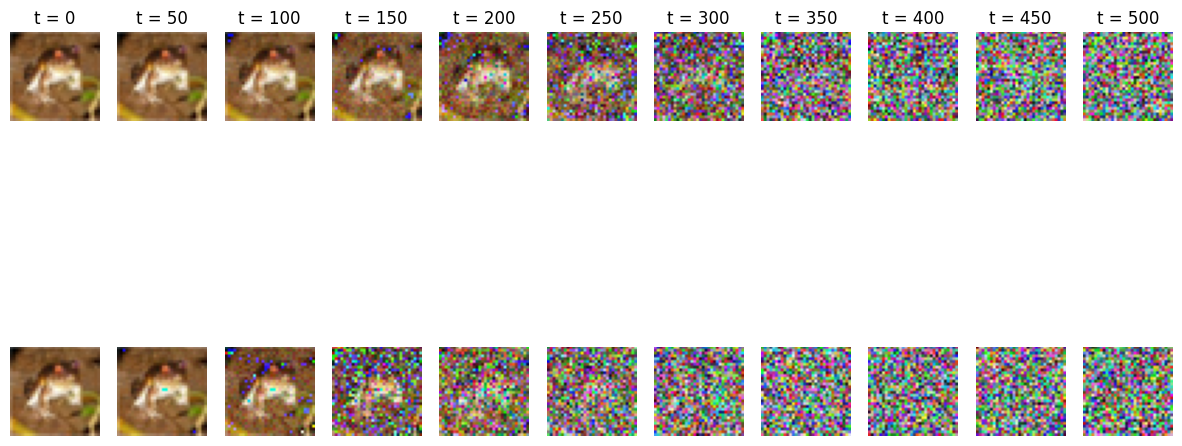

In [99]:
# So we can repeat the above diffusion process using our denoising net (which includes a diffusion process)
im, label = cifar_train[0]
images = [im]

for t in range(10):
    images.append(toy_denoise_net.dif_proc(im, 50*t))
    

figure = plt.figure(figsize=(15,15))

for i in range(11):
    figure.add_subplot(2,11,i+1)
    plt.axis("off")
    plt.title("t = {}".format(50*i))
    im = images[i].detach().numpy().transpose(1,2,0)
    plt.imshow((im*255).astype(np.uint8), cmap = "gray")
    
   
denoised_images = [images[0]]

for t in range(10):
    denoised_images.append(toy_denoise_net.denoise(images[t+1], torch.tensor([50*(t+1)-1])))
    
for i in range(11):
    figure.add_subplot(1, 11, i+1)
    plt.axis("off")
    plt.title("")
    im = denoised_images[i].detach().numpy().squeeze().transpose(1,2,0)

    plt.imshow((im*255).astype(np.uint8), cmap = "gray")

    

Obviously nothing happens, but the code at least compiles. As of now, the 'denoising neural network' is pretty silly, and in fact adds noise to the image.

<h1><center> The Diffusion Model - i.e. the loss function, sampling, etc... </center></h1>

In [100]:
class vd_model(nn.Module):
    
    def __init__(self, dif_proc, denoiser, prior):
        super().__init__()
        
        self.prior = prior
        self.dif_proc = dif_proc
        self.denoiser = denoiser 
        self.T = dif_proc.T
        
        
        
    def sample(self, x_t, t):
    #implements a single step (at a specified time step) of Algorithm 2 in Ho et al. to denoise x_t to x_{t-1}
    

        z = self.prior.rsample()
        
        var_t = self.dif_proc.variance_schedule[t]  #also referred to as beta_t for some reason
        alpha_t = 1-var_t
        
        #var_s = self.dif_proc.noise_schedule(t-1)
        #alpha_s = 1-var_s
        
        sigma_t = var_t**.5
        beta_bar = self.dif_proc.var(t)   #equals 1-alpha_bar
        
        coef = (1-alpha_t)/(beta_bar**.5)
        
        x_s = 1/(alpha_t)**5 *(x_t - coef*self.denoiser(x_t, torch.tensor([t]))) + sigma_t *z
        
        return x_s
        
        
        
        
    def gaussian_kl(self, mean_1, logvar_1, mean_2, logvar_2):
        """
        Given two Gaussian distributions p_1 and p_2, returns D_{KL}(p_1 || p_2)
        """
        
        0.5 * (-1.0 + logvar_2 - logvar_1 + torch.exp(logvar_1 - logvar_2)
                + ((mean1-mean2)**2) * torch.exp(-logvar_2))
        
    def posterior_parameters(x_0, x_t, t):
        """
        returns the mean and log-variance of q(x_{t-1} | x_t, x_0) according to equation (7) in Ho et al
        """
        
    def model_distribution_parameters(x_t, t):
        """
        returns the mean and log-variance of p(x_{t-1}|x_{t}) according to equation (11) for the mean, and the choice of sigma^2_{t} = beta_{t} as in
        the first paragraph of 3.2
        """
        
        
    def L_t(self, x_0, x_t, t):
        """
        Given a clean image x_0 and a noisy version x_t, return D_{KL}(q(x_{t-1}| x_t, x_0) || p(x_{t-1}|x_t)).
        """
        
        mu_q, logvar_q = self.posterior_parameters(x_0, x_t, t)
        
        mu_p, logvar_p = self.model_distribution_parameters(x_t, t)
        
        return gaussian_kl(mu_q, logvar_q, mu_p, logvar_p)
    
    
        
        
        
        
    def forward(self, x):
        #The forward function computes a Monte-Carlo estimate of the variational lower bound, following Kingma et al's paper. This consists of 
        #the KL divergence between the prior and the diffusion distribution q(z_1| x), the reconstruction loss (RL), and the diffusion loss.
    
    
        #KL divergence
        x_T, q_log_prob = self.dif_proc(x, self.T, inc_dist = True)
        p_xT = self.prior
        p_log_prob = p_xT.log_prob(x_T)
        
        KL = q_log_prob - p_log_prob
        KL = torch.sum(KL)
    
        #reconstruction loss - Let's ignore for now
        #x_1 = self.dif_proc(x, 0, inc_dist = False)
        #gen_dist = self.generative_dist(x_1, 0)
        
        #RL = gen_dist.log_prob(x)
        
        #Diffusion loss - note that if the noise is constant, this vanishes
        probs = 1/self.T * torch.ones(self.T)
        t_k = td.Categorical(probs).sample()
        s_k = t_k-1  
        epsilon = self.prior.rsample()
        x_k = self.dif_proc(x, t_k)    
        error = torch.nn.MSELoss()
        e_norm = error(epsilon, self.denoiser(x_k, torch.tensor([t_k])))
        
        L_T = (self.T/2)*(torch.exp(self.dif_proc.var(s_k) - self.dif_proc.var(t_k)) -1) * e_norm
        
        return KL + L_T
        
        
        
    
    

**Example**

In [86]:
toy_diffusion = diffusion_process(500, .0001, .005)
toy_net = toy_denoising_net()
toy_denoise_net = denoise_net(toy_diffusion, toy_net)

mu = torch.zeros([3,32,32])
prior = td.Normal(mu, 1)

toy_vdm = vd_model(toy_diffusion, toy_denoise_net, prior)

im, label = cifar_train[0]
images = [im]

toy_vdm(im)

tensor(381.2672, grad_fn=<AddBackward0>)

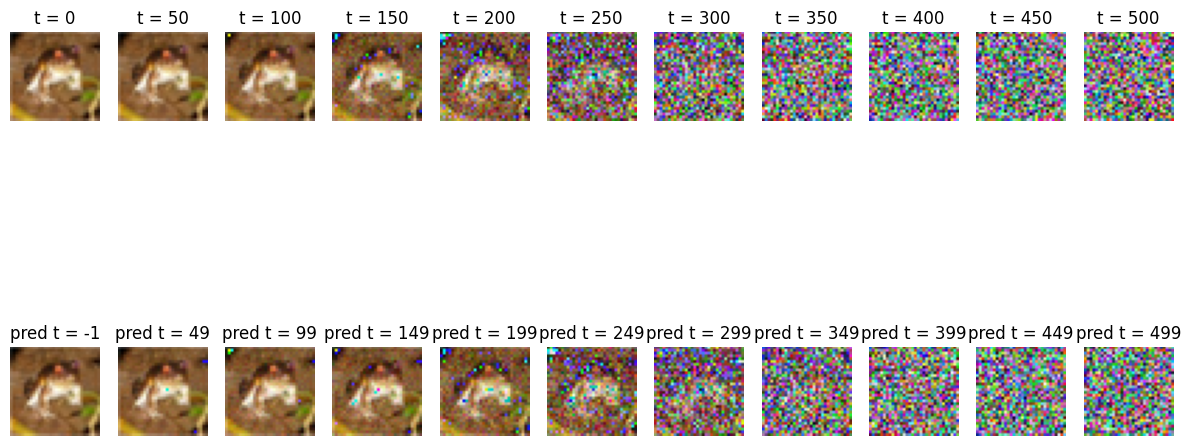

In [87]:

def plot_samples(model, im, num_ex, inc):
    """
    This function takes an image, plots the diffusion process, and plots the attempt of our model to denoise at each time_step
    
    im = input image
    num_ex = number of timesteps we wish to plot
    inc = increment of timesteps to plot
    """
    images = [im]
    images_rec = [im]

    for t in range(num_ex):
        images.append(model.dif_proc(im, inc*t))
        images_rec.append(model.sample(images[t], inc*t))
    
    figure = plt.figure(figsize=(15,15))

    for i in range(num_ex + 1):
        figure.add_subplot(2,11,i+1)
        plt.axis("off")
        plt.title("t = {}".format(inc*i))
        im = images[i].detach().numpy().transpose(1,2,0)
        plt.imshow((im*255).astype(np.uint8), cmap = "gray")
    
        figure.add_subplot(1,11, i+1)
        plt.title("pred t = {}".format(inc*i -1))
        plt.axis("off")
        im_rec = images_rec[i].detach().squeeze().numpy().transpose(1,2,0)
        plt.imshow((im_rec*255).astype(np.uint8), cmap = "gray")
        
im, label = cifar_train[0]
plot_samples(toy_vdm, im, 10, 50)

Even without training, it looks like the denoising process does try to 'denoise' the image.

**First Attempt To Train**

In [79]:
#basic training loop

def train(epochs, dataloader, opt, model):
    tot_loss = torch.zeros(epochs)
    model.train()
    
    for i in range(epochs):
        total_epoch_size = 0
        for batch, _ in dataloader:
            total_epoch_size += batch.size()[0]
            opt.zero_grad()
            loss = model(batch)
            loss.backward()
            opt.step()
            tot_loss[i] += loss.detach()
        
        tot_loss[i] = tot_loss[i]/total_epoch_size
        print("Epoch {} loss = {:.6f}".format(i+1, tot_loss[i]))

In [80]:
cifar_loader = DataLoader(cifar_train, batch_size = 64, shuffle = True)
opt = torch.optim.Adam(toy_vdm.parameters())


train(10, dataloader, opt, toy_vdm)



Epoch 1 loss = -3305.943604
Epoch 2 loss = -24660.740234
Epoch 3 loss = -63983.878906
Epoch 4 loss = -118096.046875


KeyboardInterrupt: 

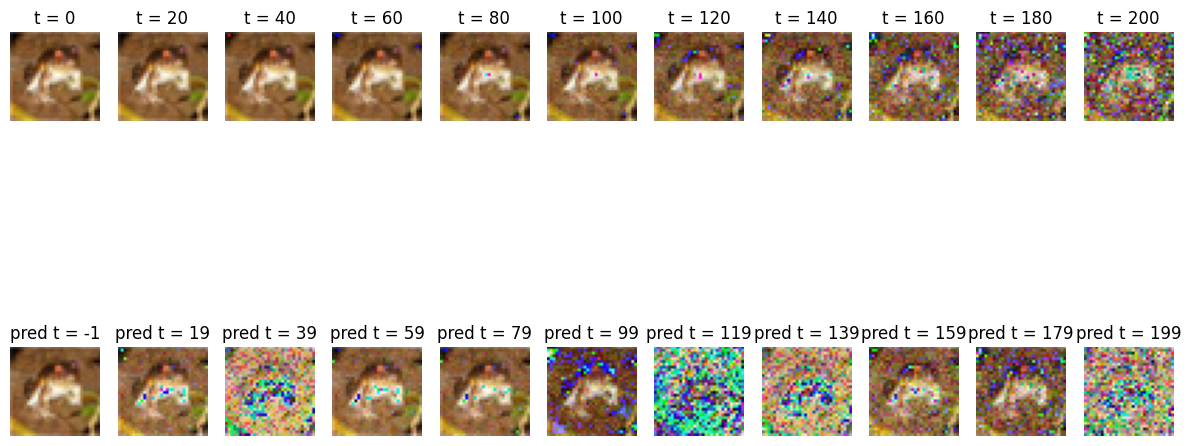

In [84]:
plot_samples(im, 10, 20)